In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import prince
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Section 1: Data Generation

The goal of this section is to create a dataset with categorical features and a continuous target variable.

First, we create a normal dataset with some preset colinearity, including a target variable. These will simply be used as a base for the categorical variables

In [2]:
corr=.7 # Correlation of target variable to the feature bases
multicol= .4 #Correlation of the feature bases to each other
size = 10000 # number of samples

mvnorm = stats.multivariate_normal(mean=[0, 0, 0, 0, 0], cov=[[1., corr, corr, corr, corr], 
                                                           [corr, 1., multicol, multicol, multicol],
                                                           [corr, multicol, 1., multicol, multicol],
                                                           [corr, multicol, multicol, 1., multicol],
                                                           [corr, multicol, multicol, multicol, 1.]])
raw = mvnorm.rvs(size)

In [3]:
#Add to a dataframe and confirm that the correlations are close
#to our inputs:
normdf = pd.DataFrame(raw)
normdf.columns = ['target', 'norm1', 'norm2', 'norm3', 'norm4']
print(normdf.shape)
normdf.corr()

(10000, 5)


,target,norm1,norm2,norm3,norm4
target,1.000000,0.698184,0.700808,0.703455,0.709930
norm1,0.698184,1.000000,0.394895,0.410650,0.403463
norm2,0.700808,0.394895,1.000000,0.393121,0.411030
norm3,0.703455,0.410650,0.393121,1.000000,0.409774
norm4,0.709930,0.403463,0.411030,0.409774,1.000000


Next, we create some discrete distributions that will represent our categories. By creating different uniform/normalc ombinations as seen below, we ensure that we'll have categories occuring at different frequencies in the dataset.

In [4]:
#Create some categorical features from the feature bases, and sort them 
#The need for sorting will become apparent in a moment
cat1 = np.sort([np.round(x,0) for x in np.random.uniform(high=10.5, low=.5, size=size)])
cat2 = np.sort([np.round(x,0) for x in np.random.uniform(high=5.5, low=.5, size=size)])
cat3 = np.sort([np.round(x,0) for x in np.random.normal(loc=0, scale=1,size=size)])
cat4 = np.sort([np.ceil(x) for x in np.random.normal(loc=0, scale=2,size=size)])

In [5]:
# #Create some categorical features from the feature bases, and sort them 
# #The need for sorting will become apparent in a moment
# cat1 = np.sort([np.round(x,0) for x in np.random.normal(loc=0, scale=1,size=size)])
# cat2 = np.sort([np.round(x,0) for x in np.random.normal(loc=0, scale=.5,size=size)])
# cat3 = np.sort([np.round(x,0) for x in np.random.normal(loc=0, scale=1,size=size)])
# cat4 = np.sort([np.ceil(x) for x in np.random.normal(loc=0, scale=2,size=size)])

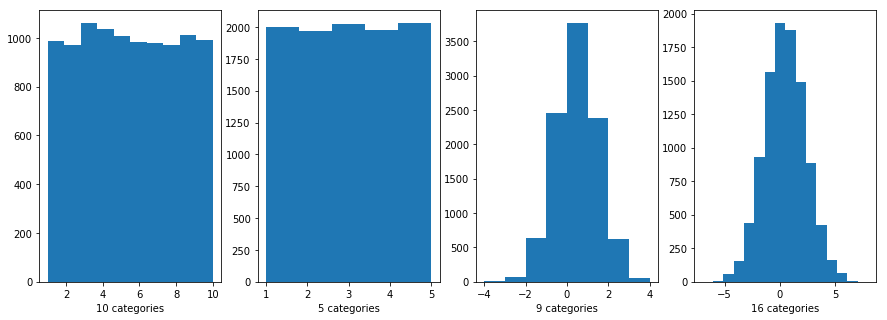

In [6]:
plt.figure(figsize=[15,5])
plt.subplot(141)
plt.hist(cat1, bins=10)
plt.xlabel(str(len(set(cat1)))+" categories")
plt.subplot(142)
plt.hist(cat2, bins=5)
plt.xlabel(str(len(set(cat2)))+" categories")
plt.subplot(143)
plt.hist(cat3, bins=8)
plt.xlabel(str(len(set(cat3)))+" categories")
plt.subplot(144)
plt.hist(cat4, bins=len(set(cat4)))
plt.xlabel(str(len(set(cat4)))+" categories")
plt.show()

By sorting the categories in the same order as the as the normal distributions generated with the multivariate function, we ensure that the categorical features will have a correlation with the target variable.

In [7]:
sortorder1 = stats.rankdata(normdf.norm1, method='ordinal')
sortorder2 = stats.rankdata(normdf.norm2, method='ordinal')
sortorder3 = stats.rankdata(normdf.norm3, method='ordinal')
sortorder4 = stats.rankdata(normdf.norm4, method='ordinal')

In [8]:
generic = pd.DataFrame({
    'target': normdf['target'],
    'feat1' : [int(cat1[i-1]) for i in sortorder1],
    'feat2' : [int(cat2[i-1]) for i in sortorder2],
    'feat3' : [int(cat3[i-1]) for i in sortorder3],
    'feat4' : [int(cat4[i-1]) for i in sortorder4]
})

### Result:
As seen below, the result of the above is a dataframe with 5 categorical variables that have strong correlations with a target variable, and moderate correlations with each other. We will convert the integers to text to obscure these relationships as a way ot simulating a real-life categorical situation.

In [9]:
generic.head()

,target,feat1,feat2,feat3,feat4
0,1.532465,10,5,1,5
1,0.722266,8,2,2,-2
2,-0.647427,4,2,-1,-2
3,0.014689,2,3,1,-1
4,-0.305632,1,4,-1,-2


In [10]:
generic.corr()

,target,feat1,feat2,feat3,feat4
target,1.000000,0.674059,0.662440,0.678209,0.701590
feat1,0.674059,1.000000,0.362287,0.383529,0.383811
feat2,0.662440,0.362287,1.000000,0.356556,0.384227
feat3,0.678209,0.383529,0.356556,1.000000,0.391726
feat4,0.701590,0.383811,0.384227,0.391726,1.000000


In [11]:
#confirming the size of the categories we need to fake:
for col in generic.columns[1:]:
    print(col, set(generic[col]))
    print(len(set(generic[col])), "to create")

feat1 {1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
10 to create
feat2 {1, 2, 3, 4, 5}
5 to create
feat3 {0, 1, 2, 3, 4, -1, -4, -3, -2}
9 to create
feat4 {0, 1, 2, 3, 4, 5, 6, 7, 8, -2, -7, -6, -5, -4, -3, -1}
16 to create


In [131]:
bestmove = ['three', 'layup', 'dunk', 'pass_oop', 'steal',
            'take_charge','midrange','pass_bounce','post_up','free_throw']

position = ['PG', 'SG', 'SF', 'PF', 'C']

sponsors = ['Nike','Reebok','Puma','Adidas','Air_Jordan','Fila','Under_Armour','AND1']

team = ['Knicks','Lakers','Bulls','Thunder','Heat','Clippers','Nets',
        'Rockets','Raptors','Hawks','Warriors','Blazers','Magic','Suns',
        'Celtics','Bobcats','76ers','Kings','Jazz','Spurs', 'Pistons', 'Bucks']

headband = ['Always','Never']

movie = ['Inception','The_Prestige', 'The Matrix','The_Avengers',
        'Pulp_Fiction','The_GodFather', 'Annihilation','Jaws']

In [132]:
df = pd.DataFrame({
    'all_star_votes': [int(x*10000+1e5) for x in generic['target']],
    'best_move': [bestmove[i-1] for i in generic['feat1']],
    'position': [position[i-1] for i in generic['feat2']],
    'shoe_sponsor': [sponsors[i-1] for i in generic['feat3']],
    'team': [team[i-1] for i in generic['feat4']],
    'wears_headband': [np.random.choice(headband) for _ in range(size)],
    'favorite_movie': [np.random.choice(movie) for _ in range(size)],
})
df.head()

,all_star_votes,best_move,position,shoe_sponsor,team,wears_headband,favorite_movie
0,115324,free_throw,C,Nike,Heat,Always,Jaws
1,107222,pass_bounce,SG,Reebok,Spurs,Never,The_Avengers
2,93525,pass_oop,SG,Under_Armour,Spurs,Always,Annihilation
3,100146,layup,SF,Nike,Pistons,Never,The_Prestige
4,96943,three,PF,Under_Armour,Spurs,Always,Inception


# Section 2: PCA vs MCA for dimensionality Reduction with Categorical Variables

### One-hot encoded: Regression Baseline

In [133]:
y = df.all_star_votes
Xcat = df.drop('all_star_votes', axis=1)
X = pd.get_dummies(Xcat, drop_first=True)
print(X.shape)
X.head()

(10000, 43)


,best_move_free_throw,best_move_layup,best_move_midrange,best_move_pass_bounce,best_move_pass_oop,best_move_post_up,best_move_steal,best_move_take_charge,best_move_three,position_PF,...,team_Spurs,team_Thunder,wears_headband_Never,favorite_movie_Inception,favorite_movie_Jaws,favorite_movie_Pulp_Fiction,favorite_movie_The Matrix,favorite_movie_The_Avengers,favorite_movie_The_GodFather,favorite_movie_The_Prestige
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1,1,...,1,0,0,1,0,0,0,0,0,0


In [134]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

In [135]:
regr = LinearRegression()
regr.fit(X_train, y_train)

print(regr.score(X_train, y_train))
print(regr.score(X_test, y_test))

0.8691980085231028
0.8666521173418834


In [136]:
lasso = LassoCV()
lasso.fit(X_train, y_train)
lasso.score(X_test, y_test)

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.8655187471521615

In [137]:
coefs = lasso.coef_
for i, col in enumerate(X.columns):
    print(col, ":", coefs[i])

best_move_free_throw : 8167.018243071792
best_move_layup : -1260.8389258270638
best_move_midrange : 3676.0425722454556
best_move_pass_bounce : 4316.725934192469
best_move_pass_oop : 1026.6098356798839
best_move_post_up : 5476.48198078515
best_move_steal : 1793.2190861620902
best_move_take_charge : 2533.6060780227517
best_move_three : -3648.5123623268705
position_PF : -2719.1892642254943
position_PG : -9112.674377853453
position_SF : -4435.923279101852
position_SG : -6561.164615477116
shoe_sponsor_Adidas : -4772.456515799556
shoe_sponsor_Air_Jordan : -8582.908058228517
shoe_sponsor_Fila : -5902.135254216073
shoe_sponsor_Nike : 2790.9358868482386
shoe_sponsor_Puma : 9013.032710180321
shoe_sponsor_Reebok : 6212.657523351663
shoe_sponsor_Under_Armour : -3154.775941821879
team_Bobcats : -0.0
team_Bucks : 6054.1735454853715
team_Bulls : 10978.345574158935
team_Celtics : -0.0
team_Clippers : 16698.138049059144
team_Heat : 14140.598921523357
team_Jazz : 910.1153163912268
team_Kings : -682.2604

## Analysis: 
This model has way too many parameters, and is therefore horrifically overfitting to the point of being useless. 
We need some way to reduce the dimensions.

### PCA

In [138]:
pca = PCA(n_components=10)

In [139]:
scaledX = StandardScaler().fit_transform(X)
pca_components = pca.fit_transform(scaledX)

c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [140]:
print([round(x,2) for x in pca.explained_variance_ratio_])
print(np.sum(pca.explained_variance_ratio_))

[0.05, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03]
0.3070439803079164


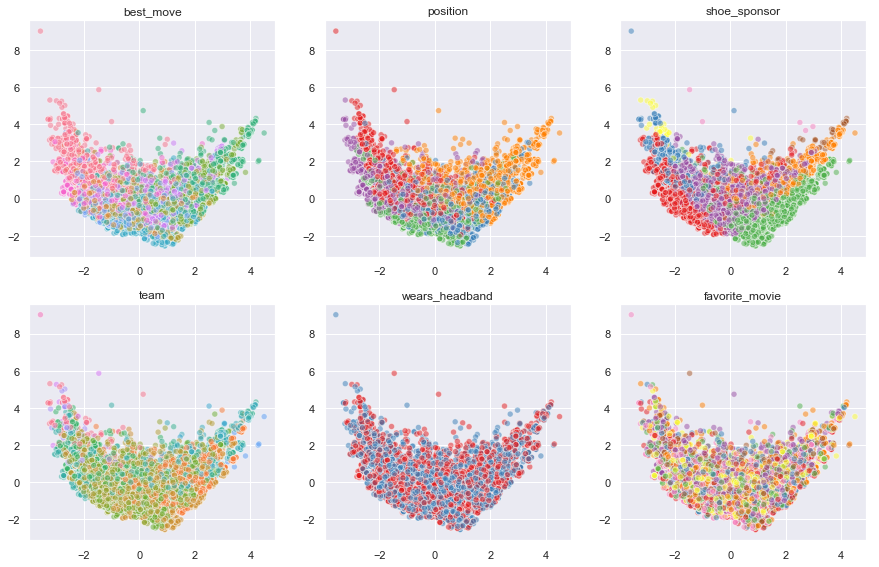

In [141]:
sns.set_palette("Set1")
fig = plt.figure(figsize=[15,20])
for i,col in enumerate(df.columns[1:]):
    fig.add_subplot(4,3,i+1)
    sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=df[col], 
                    alpha=.5, legend=False)
    plt.title(col)
plt.show()

# MCA

In [142]:
mca = prince.MCA(n_components=10)
mca.fit(Xcat)

MCA(check_input=True, copy=True, engine='auto', n_components=10, n_iter=10,
  random_state=None)

In [143]:
mca.total_inertia_

7.166666666666667

In [144]:
print([round(x,2) for x in mca.explained_inertia_])
print(np.sum(mca.explained_inertia_))

[0.05, 0.03, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02]
0.28225020065177336


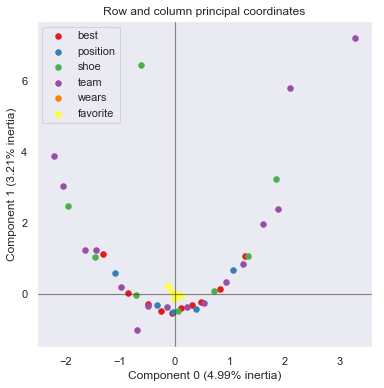

In [145]:
ac = mca.plot_coordinates(X=Xcat,
     ax=None,
     figsize=(6, 6),
     show_row_points=False,
     row_points_size=1,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=False,
     legend_n_cols=1)

In [146]:
mca_components = mca.transform(Xcat)
mca_components.head()

,0,1,2,3,4,5,6,7,8,9
0,1.304701,1.307258,-0.208992,-0.893998,-0.378948,0.599132,0.782207,-0.475772,-0.067489,-0.746618
1,0.128873,0.201058,-0.303896,-0.065432,0.592919,0.248867,-0.019719,0.198813,-0.954516,0.429799
2,-0.623870,-0.215352,0.224044,-0.792033,-0.304895,0.281519,0.058702,0.502405,-0.159007,-0.655961
3,-0.175377,-0.286420,-0.088372,-0.381789,0.365039,-0.798271,-0.123573,0.032204,-0.050051,-0.129201
4,-0.759400,0.370804,0.230479,0.056826,0.084773,0.561335,-0.111015,0.695769,0.073666,-0.071634


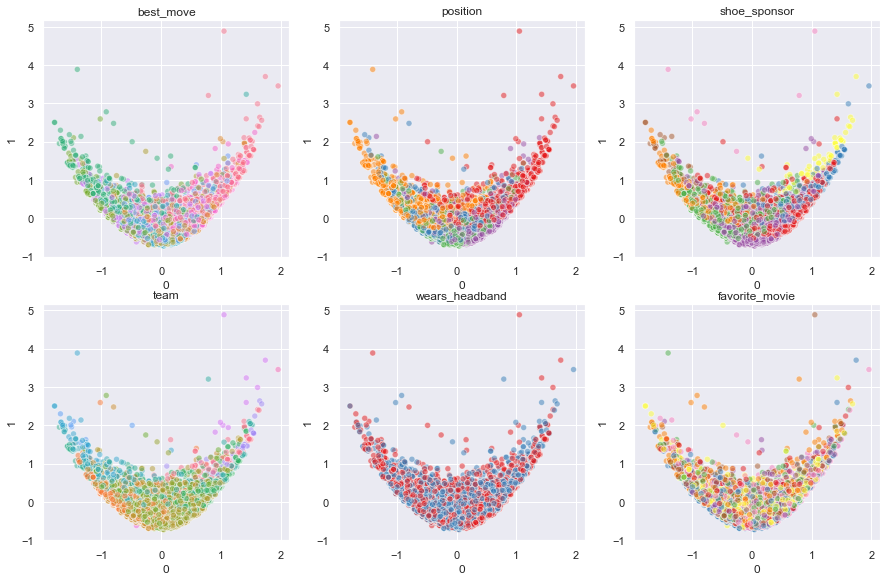

In [147]:
sns.set_palette("Set1")
fig = plt.figure(figsize=[15,20])
for i,col in enumerate(df.columns[1:]):
    fig.add_subplot(4,3,i+1)
    sns.scatterplot(x=mca_components[0], y=mca_components[1], hue=df[col], 
                    alpha=.5, legend=False)
    plt.title(col)
plt.show()

Guttman Effect: First dimension has found a linear relationship, and the second is separating high and low outliers from the rest of the items.

# Comparing them both with a simple regression

In [148]:
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(
    pca_components, y, test_size=0.33)

mca_X_train, mca_X_test, mca_y_train, mca_y_test = train_test_split(
    mca_components, y, test_size=0.33)

In [149]:
#PCA:
regr.fit(pca_X_train, pca_y_train)
print(regr.score(pca_X_train, pca_y_train))
print(regr.score(pca_X_test, pca_y_test))

0.8133599169610979
0.8037096322808651


In [150]:
#MCA:
regr.fit(mca_X_train, mca_y_train)
print(regr.score(mca_X_train, mca_y_train))
print(regr.score(mca_X_test, mca_y_test))

0.8681246674475984
0.8649220854306401


In [157]:
def anova_viz(oneHotDf, comp1, comp2):
    results = []
    for cat in oneHotDf.columns:
        #set up temporary dataframe for easy slicing
        df = pd.DataFrame({
            cat : oneHotDf[cat],
            'comp1': comp1,
            'comp2': comp2
        })
        #First dimension
        mean_tot = df['comp1'].mean()
        mean_negs = df[df[cat]==0]['comp1'].mean()
        mean_pos = df[df[cat]==1]['comp1'].mean()
        count_negs = df[df[cat]==0]['comp1'].count()
        count_pos = df[df[cat]==1]['comp1'].count()
        top = count_negs*(mean_negs-mean_tot)**2 + count_pos*(mean_pos-mean_tot)**2
        bottom = np.sum([(x-mean_tot)**2 for x in df['comp1']])
        p1 = top/bottom
        #Second Dimension
        mean_tot = df['comp2'].mean()
        mean_negs = df[df[cat]==0]['comp2'].mean()
        mean_pos = df[df[cat]==1]['comp2'].mean()
        count_negs = df[df[cat]==0]['comp2'].count()
        count_pos = df[df[cat]==1]['comp2'].count()
        top = count_negs*(mean_negs-mean_tot)**2 + count_pos*(mean_pos-mean_tot)**2
        bottom = np.sum([(x-mean_tot)**2 for x in df['comp2']])
        p2 = top/bottom
        #Store
        results.append((cat, p1, p2))
    rdf = pd.DataFrame(results, columns=['label','dim1','dim2'])
    plt.figure(figsize=[15,15])
    fig = sns.scatterplot(x='dim1', y='dim2', hue='label',
                          data=rdf, legend=False, s=200)
    for point in range(0,rdf.shape[0]):
        fig.text(rdf.dim1[point]+0.005, rdf.dim2[point], 
        rdf.label[point], horizontalalignment='left', 
            size='medium', color='grey', weight='semibold')
    plt.show()
    return rdf

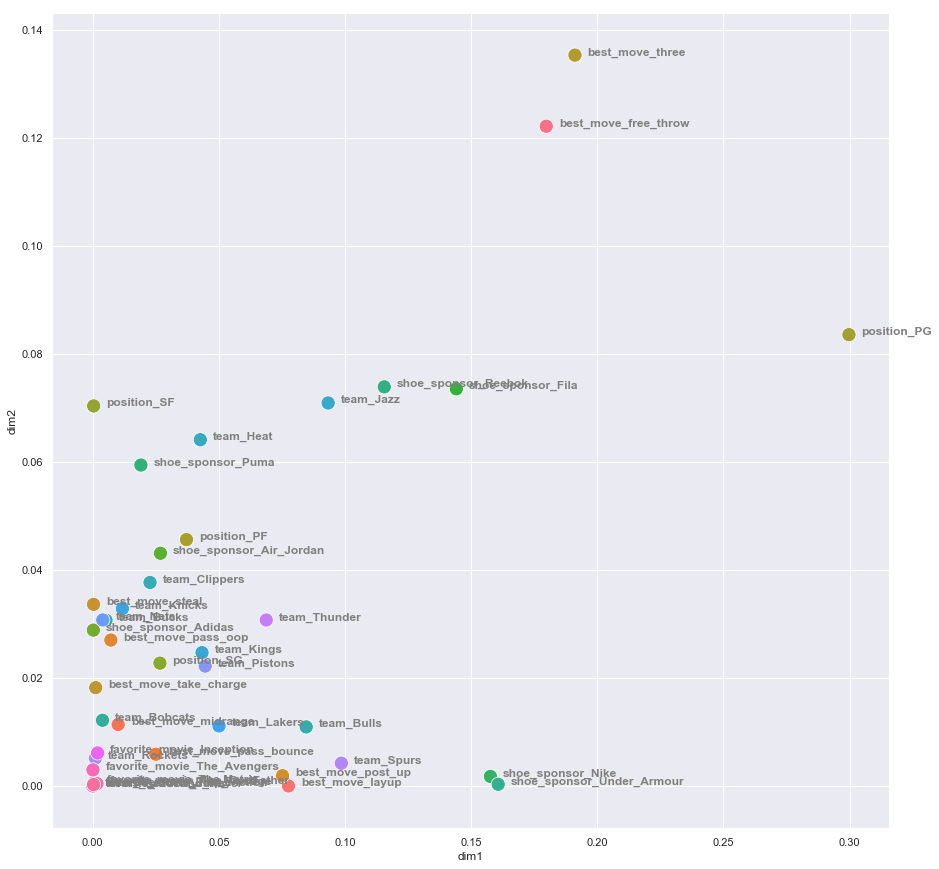

In [158]:
sns.set()
mca_anova = anova_viz(X,mca_components[0],mca_components[1])

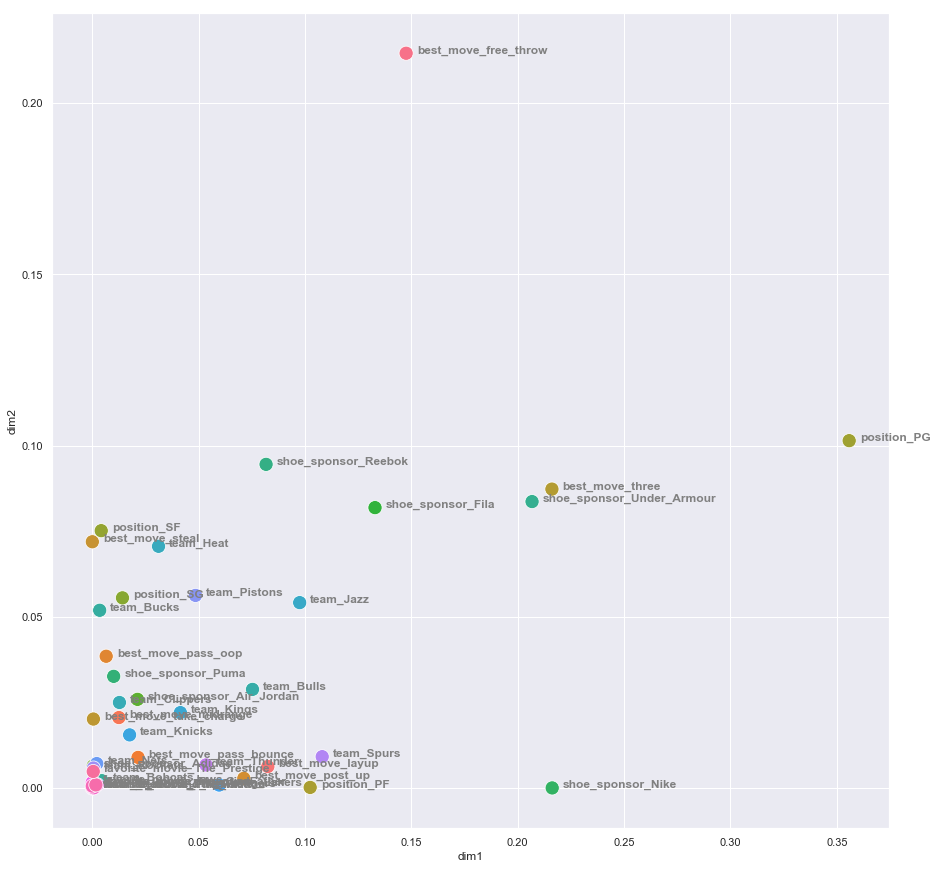

In [159]:
pca_anova = anova_viz(X,pca_components[:,0], pca_components[:,1])

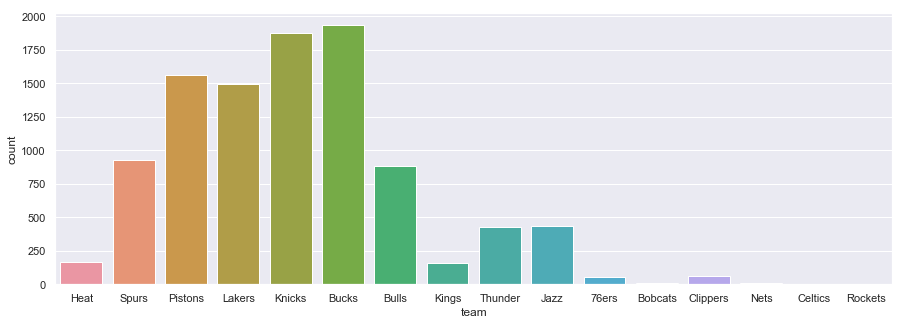

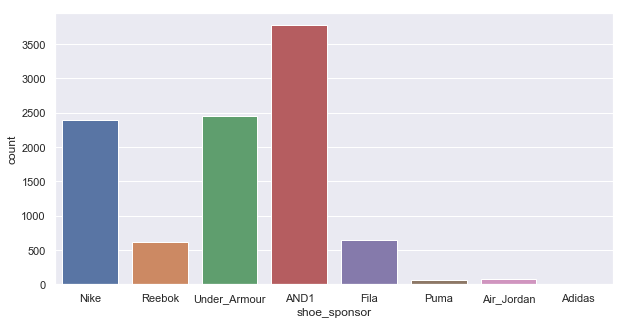

In [154]:
plt.figure(figsize=[15,5])
sns.countplot(df.team)
plt.show()
plt.figure(figsize=[10,5])
sns.countplot(df.shoe_sponsor)
plt.show()